# Homework 4: SVM


This assignment is due on Moodle by **11:59pm on Friday November 8**. 
Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.
Your solutions to computational questions should include any specified Python code and results 
as well as written commentary on your conclusions.
Remember that you are encouraged to discuss the problems with your instructors and classmates, 
but **you must write all code and solutions on your own**. For a refresher on the course **Collaboration Policy** click [here](https://github.com/BoulderDS/CSCI5622-Machine-Learning/blob/master/info/syllabus.md#collaboration-policy).

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda (Version: 2019.07) with Python 3.7. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 
- In this homework you will explore the primal and dual representations of support vector machines, as well as the performance of various kernels while classifying sentiments. Install the following packages: `nltk` (Version: 3.4.5), `scikit-learn` (Version: 0.21.3)


Name: **Andrew Gerlach ange6809**

In [1]:
import math
import pickle
import gzip
import numpy as np
import pandas
import matplotlib.pylab as plt
%matplotlib inline

[40 Points] Problem 1 - Basic concepts of SVM
---

**Part 1 [10 points]:** 
* What are the main differences between the primal and the dual representations?
* For the variables $\xi_i$, $C$ in the primal formation, what are their roles? Write out the upper/lower bounds (constraints) of these variables. What are the interpretation for these maximum/minimum values?
* For the variable $\alpha_i$, $\beta_i$ in the dual formation, what are the upper/lower bound (constraints) of them?

The primal representation involves classifying a point using the weight vector. This can be difficult for high-dimensional data. The dual problem uses the training data to construct the weight vector into $w = \sum_{i = 1}^{n} \alpha_iy_ix_i$. In this representation the objective function optimizes over the $\alpha_i$'s. The only $\alpha$ that won't be zero will be the ones associated with the suppoert vectors, making this representation much easier to compute.

$\xi$ is used in the primal problem as a way to prevent overfitting when not using a kernel function. It allows for some misclassified points within a certain range (slack). $C$ determines the penatly for allowing the misclasified points. $\xi \geq 0$ and $C > 0$. Each $xi_i$ must be non-megative to prevent having negative slack. The higher $xi$ is, the more misclassifications you allow. The higher $C$ is, the more you penalize allowing misclassified points.


$\alpha_i \geq 0$ and $\beta_i \geq 0$ and $\alpha_i + \beta_i = C$

**Part 2 [20 points]:** 

 * Given a weight vector, implement the `find_support` function that returns the indices of the support vectors.
 * Given a weight vector, implement the `find_slack` function that returns the indices of the vectors with nonzero slack.
 * Given the alpha dual vector, implement the `weight_vector` function that returns the corresponding weight vector.

In [2]:
class SVM:
    
    def __init__(self):
        self.kINSP = np.array([(1, 8, +1),
                       (7, 2, -1),
                       (6, -1, -1),
                       (-5, 0, +1),
                       (-5, 1, -1),
                       (-5, 2, +1),
                       (6, 3, +1),
                       (6, 1, -1),
                       (5, 2, -1)])
        self.kSEP = np.array([(-2, 2, +1),    # 0 - A
                      (0, 4, +1),             # 1 - B
                      (2, 1, +1),             # 2 - C
                      (-2, -3, -1),           # 3 - D
                      (0, -1, -1),            # 4 - E
                      (2, -3, -1),            # 5 - F
                      ])


    def weight_vector(self, x, y, alpha):
        """
        Given a vector of alphas, compute the primal weight vector w.
        The vector w should be returned as an Numpy array.
        """

        w = np.zeros(len(x[0]))
        # YOUR CODE HERE
        size = x.shape[0]
        for i in range(len(w)):
            for j in range(size):
                w[i] = w[i] + alpha[j] * x[j][i] * y[j]
        return w


    def find_support(self, x, y, w, b, tolerance=0.001):
        """
        Given a set of training examples and primal weights, return the indices
        of all of the support vectors as a set.
        """

        support = set()
        # YOUR CODE HERE
        for i in range(len(x)):
            curr = y[i] * (np.dot(x[i],w) + b)
            if np.absolute(curr - 1) <= tolerance:
                support.add(i)
        return support



    def find_slack(self, x, y, w, b):
        """
        Given a set of training examples and primal weights, return the indices
        of all examples with nonzero slack as a set.
        """

        slack = set()
        # YOUR CODE HERE
        for i in range(len(x)):
            curr = y[i] * (np.dot(x[i],w) + b)
            if 1 - curr > 0:
                slack.add(i)
        return slack

In [3]:
from tests import tests
tests.run_test_suite("prob 1", SVM)

TestWideSlack (tests.tests.TestSVM) ... ok
TestNarrowSlack (tests.tests.TestSVM) ... ok
TestSupport (tests.tests.TestSVM) ... ok
TestWeight (tests.tests.TestSVM) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


**Part 3 [10 points]:** 

The goal of this problem is to correctly classify test data points, given a training data set.
For this problem, assume that we are training an SVM with a quadratic kernel, which means our kernel function is a polynomial kernel of degree 2. You are given the data set presented in the figure below. The slack penalty $C$ will determine the location of the decision boundary.

Justify the following questions in a sentence or via drawing decision boundary.
![training_data](./data/data.png)

* Where would the decision boundary be for very large values of $C$ ?
* Where you would expect the decision boundary to be if  $C = 0$ ?
* Which of the two cases above would you expect to generalize better on test data? Why?

Because the kernel function is of degree 2, the large values for C would create a circle around the cluter of o's, excluding the 2 +'s in that cluster. For C = 0 the decision boundary would be a straight line of slope -1 that splits the 2 clusters down the middle. The better generalization would come from C = 0, because that classifier would be less overfit.

[30 points] Problem 2 - The Kernel Trick
---
The kernel trick can make SVM powerful and become non-linear. In this problem we will get familiar with the kernel trick.

**Part 1 [10 points]:**

We will construct a support vector machine that computes the XOR function, using values of +1 and −1 (instead of 1 and 0) for both inputs and outputs, so that an example looks like ($[−1, 1], 1$) or ($[−1, −1], −1$). Map the input $[x_1, x_2]$ into a space consisting of $x_1$ and $x_1x_2$. Plot the four input points in this space, and the maximal margin separator. Give the margin value in the markdown cell. Remeber to indicate which points have output +1 and which -1.

Text(0.5, 1.0, 'XOR using [x1 , x1x2]')

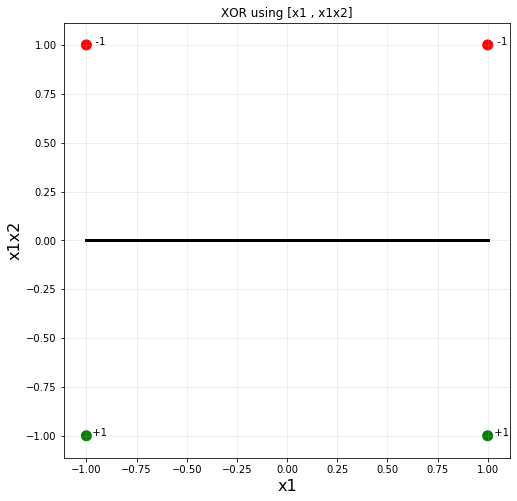

In [4]:
# YOUR CODE HERE
data = np.array([[-1,-1,-1],[-1,1,1],[1,-1,1],[1,1,-1]])
x1 = data[:,0:1]
x2 = data[:,1:2]
x1x2 = x1 * x2

colors = []
for i in range(len(x1x2)):
    if x1x2[i] == 1:
        colors.append("red")
    else:
        colors.append("green")
txt = []
for i in range(len(x1x2)):
    if x1x2[i] == 1:
        txt.append("   -1")
    else:
        txt.append("  +1")
    
#Create an SVM to find the margind create the line
margin = SVM()
alpha = [1,1,1,1]
w = margin.weight_vector(x = x1, y = x1x2, alpha = alpha)

#plot in puts and max margin separator
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.scatter(x1, x1x2,c = colors, s = 100)
x_plot = x1
y_plot = w * x1
for i in range(len(txt)):
    plt.annotate(txt[i],xy=(x1[i],x1x2[i]))
ax.plot(x_plot,y_plot,lw=3,color="black")
ax.grid(alpha=0.25)
ax.set_xlabel("x1", fontsize=16)
ax.set_ylabel("x1x2", fontsize=16)
ax.set_title("XOR using [x1 , x1x2]")

From the plot, the margin = 1.

**Part 2 [5 points]:** Plot the separating line of **Part 1** back in the original Euclidean input space.

Text(0.5, 1.0, 'XOR using [x1 , x2]')

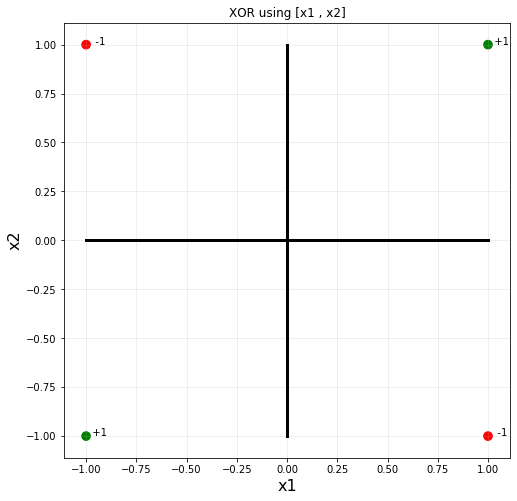

In [5]:
# YOUR CODE HERE
# YOUR CODE HERE
data = np.array([[-1,-1,-1],[-1,1,1],[1,-1,1],[1,1,-1]])
x1 = data[:,0:1]
x2 = data[:,1:2]
y = data[:,2]

colors = []
for i in range(len(y)):
    if y[i] == 1:
        colors.append("red")
    else:
        colors.append("green")
txt = []
for i in range(len(x1x2)):
    if y[i] == 1:
        txt.append("   -1")
    else:
        txt.append("  +1")  

    
#Create an SVM to find the margind create the line
margin = SVM()
w = margin.weight_vector(x=x1,y=x2,alpha=[1,1,1,1])

#plot in puts and max margin separator
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.scatter(x1, x2,c = colors, s=75)
x_plot1 = x1
y_plot1 = w * x1

#flip the values to make split
x_plot2 = w * x1
y_plot2 = x1

for i in range(len(txt)):
    plt.annotate(txt[i],xy=(x1[i],x2[i]))
    
ax.plot(x_plot1,y_plot1,lw=3,color="black")
ax.plot(x_plot2,y_plot2,lw=3,color="black")
ax.grid(alpha=0.25)
ax.set_xlabel("x1", fontsize=16)
ax.set_ylabel("x2", fontsize=16)
ax.set_title("XOR using [x1 , x2]")

**Part 3 [5 points]:** Is the separater in **Part 1** linear? Is the one in **Part 2** linear? Explain your answer.

Part 1 is linear. All of the +1 points are seaprated from the -1 points by a single separating hyperplane. Part 2 in NOT linear. There is more than one separating hyperplane.

**Part 4 [10 points]:**
The key point of the so-called “kernel trick” in SVMs is to learn a classifier that effectively separates the training data in a higher dimensional space without having to explicitly compute the representation $\phi(\mathbf{x})$ of every point $\mathbf{x}$ in the original input space. Instead, all the work is done through the kernel function $K(\mathbf{x}_i, \mathbf{x}_j)$, for example, we can use $K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)\phi(\mathbf{x}_j)$.

Show how to compute the squared Euclidean distance in the projected space between any two points $\mathbf{x}_i$, $\mathbf{x}_j$ in the original space without explicitly computing the $\phi$ mapping, instead using the kernel function $K$. In other words, derive $d(\phi(\mathbf{x}_i), \phi(\mathbf{x}_j))$ into a form using only the kernel function.

\begin{equation*}
(d(\phi(x_i),\phi(x_j)))^2 = \sum_{k=0}^{N} (\phi(x_i)_k - \phi(x_j)_k)^2 = \sum_{k=0}^{N} (\phi(x_i)_k\phi(x_i)_k - 2\phi(x_i)_k\phi(x_j)_k + \phi(x_j)_k\phi(x_j)_k = K(x_i,x_i) - 2K(x_i,x_j) + K(x_j,x_j)
\end{equation*}

[30 points] Problem 3 - SVM with `sklearn`
---

In this problem, you will get familiar with important practical functions in scikit-learn such as pipeline, grid search, and cross validation. You will experiment with these using support vector machines.

Note that grid search can take some time on your laptop, so make sure that your code is correct with a small subset of the training data and search a reasonable number of options.

* Use the Sklearn implementation of support vector machines to train a classifier to distinguish Positive and negative sentiments
* Experiment with linear, polynomial, and RBF kernels. First, perform a GridSearch over each kernel function and a small set of parameters defined over a wide range to help narrow down the search space.
* Then choose the best performing kernel from your coarse scale search and define a narrower set of parameters for random search to further optimize the hyperparameters. Comment on the experiments you ran and optimal hyperparameters you found.
Hint: http://scikit-learn.org/stable/modules/grid_search.html
* Evaluate classification performance for each model for optimal parameters by testing on a hold-out set.

Following is a dataset containing reviews and sentiments associated with it.

We will create a SVM Classifier to predict positive or negative sentiments.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
reviews  = pd.read_csv('./data/reviews.csv')
train, test = train_test_split(reviews, test_size=0.2, random_state=5622)
print(len(reviews))
X_train = train['reviews']
X_test = test['reviews']
y_train = train['sentiment']
y_test = test['sentiment']

5000


In [7]:
len(X_train),sum(y_train),len(X_test),sum(y_test)

(4000, 1995, 1000, 505)

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

**Part 1 [5 points]:**

Use `CountVectorizer` to vectorize reviews as dictionary of term frequencies.
Define the crossvalidation split using `StratifiedKFold`.

In [9]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

nltk.download('stopwords')
en_stopwords = set(stopwords.words("english")) 

# CREATE CountVectorizer using sklearn.feature_extraction.text.CountVectorizer
# Hint: use the above tokenize function
# Hint: play with different parameters, in particular, min_df can help with generalizability
# YOUR CODE HERE
vector = CountVectorizer(stop_words = en_stopwords, tokenizer = tokenize, min_df = 0.1)
# X = vector.fit_transform(X_train)
# a = X.toarray()

# split dataset using StratifiedKFold into 5 splits using sklearn.model_selection.StratifiedKFold.
# YOUR CODE HERE
kfold = StratifiedKFold(n_splits = 5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajger\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Part 2 [10 points]:**
* Create a pipeline with our `CountVectorizer` object in **Part 1** and an SVM Classifier.
* Create and fit a `GridSearchCV` object with the following parameter values:
  * Linear kernel, $C = 0.01, 1.0, 10.0$
  * Polynomial kernel, $\text{degree} = 2, 3$, $\gamma = 0.1, 0.5, 1$
  * RBF kernel, $\gamma = 0.1, 0.5, 1$
* Report accuracy on the best estimator from our `GridSearchCV` object.

In [10]:
np.random.seed(5622)
# Define pipeline using make_pipeline with vectorizer and SVM Classifier
# YOUR CODE HERE
pl = make_pipeline(vector,SVC())

# Create GridSearchCV with pipeline and the grid search parameters given above,
# using "accuracy" for scoring.

# YOUR CODE HERE
# Create a dictionary that contains the different types of kernelk functions and their corresponding parameters

parameters = [{'svc__kernel': ['linear'], 'svc__C': [0.01, 1.0, 10.0]}, 
 {'svc__kernel' : ['poly'], 'svc__degree' : [2, 3], 'svc__gamma' : [0.1, 0.5, 1.0] },
 {'svc__kernel': ['rbf'], 'svc__gamma': [0.1, 0.5, 1.0]}]

grid_svm = GridSearchCV(pl, param_grid = parameters,cv = kfold, scoring = 'accuracy')

# For debugging purposes, it makes sense to use a smaller set of training set to speed up the grid search progress
find_best = grid_svm.fit(X_train, y_train)

In [11]:
# Report best parameters and CV score from grid search
# YOUR CODE HERE
print("CV results: ", find_best.cv_results_)
print("Best CV score: ", find_best.best_score_)
print("Best Parameters: ", find_best.best_params_)

CV results:  {'mean_fit_time': array([ 3.59141679,  6.23845177, 24.86089311, 12.04587903, 14.31378045,
       14.55974927, 12.30354214, 14.97877622, 15.06694651,  4.17274079,
        4.14377604,  4.14277396]), 'std_fit_time': array([0.02117205, 0.36477458, 2.24532749, 0.9003516 , 1.0994073 ,
       0.51598425, 1.32030113, 1.21994397, 1.15189157, 0.06086069,
       0.0432896 , 0.0458747 ]), 'mean_score_time': array([0.81625972, 0.77022171, 0.77878561, 0.79286289, 0.74727407,
       0.73497868, 0.74116516, 0.71287727, 0.71430497, 0.98505993,
       0.99499145, 0.99760351]), 'std_score_time': array([0.0088077 , 0.00718239, 0.00952806, 0.02138265, 0.01672369,
       0.00973149, 0.01387824, 0.00772484, 0.0051225 , 0.02418334,
       0.01186991, 0.01263631]), 'param_svc__C': masked_array(data=[0.01, 1.0, 10.0, --, --, --, --, --, --, --, --, --],
             mask=[False, False, False,  True,  True,  True,  True,  True,
                    True,  True,  True,  True],
       fill_value='?',
 

**Part 3 [10 points]:**

Choose the best performing kernel and parameter values from your coarse scale grid search and use them to set up a narrower range of parameter values. We will use randomized grid search to sample a fixed number of these candidate parameter sets for cross validation. The number of sampled parameter sets `n_iter` provides a trade-off between computational cost and quality of the "optimal" parameters. Feel free to experiment with different values of this parameter, but please change it back to `n_iter = 5` before submitting your assignment.

In [12]:
# Set random seed for deterministic output
np.random.seed(5622)

# Set param_grid to a dictionary containing parameter values for fine scale search.

# Make a new dictionary based on what the best was above with 5 values for the paramters
param_grid = {'svc__kernel': ['linear'], 'svc__C': [0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015]}
# Create randomized parameter search over fine scale grid;
# Do NOT change the value of n_iter in the submitted version of your notebook.
n_iter = 5
random_svm = RandomizedSearchCV(pl,
                                param_grid,
                                n_iter = n_iter,
                                cv = kfold,
                                scoring = "accuracy",
                                verbose = 1,   
                                n_jobs = -1)

svm_rand_linear = random_svm.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   40.1s finished


In [13]:
# Report best parameters and CV score from grid search
# YOUR CODE HERE
print("CV results: ",svm_rand_linear.cv_results_)
print("Best CV score: ", svm_rand_linear.best_score_)
print("Best Parameters: ", svm_rand_linear.best_params_)

CV results:  {'mean_fit_time': array([7.57321024, 8.0640233 , 9.14352717, 8.93294377, 8.0048666 ]), 'std_fit_time': array([0.07065048, 0.77622316, 0.0746529 , 0.15606782, 1.81401819]), 'mean_score_time': array([1.98964906, 2.05381422, 2.23024859, 1.99323659, 1.76032739]), 'std_score_time': array([0.05191829, 0.09987477, 0.05300112, 0.09300238, 0.4693255 ]), 'param_svc__kernel': masked_array(data=['linear', 'linear', 'linear', 'linear', 'linear'],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_svc__C': masked_array(data=[0.007, 0.01, 0.006, 0.011, 0.009],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'svc__kernel': 'linear', 'svc__C': 0.007}, {'svc__kernel': 'linear', 'svc__C': 0.01}, {'svc__kernel': 'linear', 'svc__C': 0.006}, {'svc__kernel': 'linear', 'svc__C': 0.011}, {'svc__kernel': 'linear', 'svc__C': 0.009}], 'split0_test_score': array([0.74  , 0.

In [14]:
def report_results(model, X, y):
    pred = model.predict(X)        
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [15]:
report_results(random_svm.best_estimator_, X_test, y_test)

{'f1': 0.7475915221579962,
 'acc': 0.738,
 'precision': 0.7279549718574109,
 'recall': 0.7683168316831683}

**Part 4 [5 points]:**

Explain the overall procedure, and report the final result including which hyperparameter values were chosen. Make sure to explain your reasoning in choosing a refined parameter search space in **Part 3**.

Creating the pipeline allows us to run several different kernel functions alongside the SVC. When running the different kernel functions - rbf, polynomial, and linear - with a range of values for their corresponding parameters, the best result came from a linear kernel with C = 0.01. A refined search space centerede around 0.01 was then used and the best result came from C = 0.011.

### Optional survey.
***

We are always interested in your feedback. At the end of each homework, there is a simple anonymous feedback [survey](https://forms.gle/bEaNM6G2qFRKhU4Z9) to solicit your feedback for how to improve the course.